# BMI 203 Final Project Write Up

## Imports and Plotting Functions

In [1]:
def auc_roc(e, p):
    fpr, tpr, thresh = metrics.roc_curve(e, p, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC = " + str(AUC))

In [32]:
import os
import sys
from Bio import SeqIO
from Bio.Seq import Seq
import numpy as np
import random
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import scripts.NN as NN
import scripts.IO_utils as io

## Part 1: 8x3x8 Autoencoder

I have developed an autoencoder that can reconstruct and 8x8 identity matrix using 3 nodes in the hidden layer. All code called here is held and documented in scripts/NN.py

In [3]:
id_mat = np.identity(8)

In [4]:
id_mat

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [5]:
nn = NN.NeuralNetwork(id_mat, output_dim = 8, reg_term = 0.00001, expected_out = 'auto')
err = nn.fit()
err = nn.fit()
err = nn.fit()
err = nn.fit()

In [6]:
nn.l2.round(1)

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [7]:
mse = np.average(np.square(nn.backprop()))
mse

0.004379501056743855

## Part 2: Devlop Neural Network for Prediction

### Preprocessing Approach

All code descibed here is implemented and documented in scripts/IO_utils.py    

To preprocess the data, I read in both the positive and negative examples, then compute the reverse complement of the positive examples.  

I next remove all instances of a positive example that may occur in the negative sites file.  

The master training set is then composed of a fraction randomly shuffled subset of negative sites, along with the same fraction of positive sites. 

In [8]:
pos_seqs = io.read_positives()
neg_seqs = io.read_negatives(pos_seqs)

/Users/egilbertson/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:182: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  BiopythonWarning,


In [9]:
pos_seqs[0]

'ACATCCGTGCACCTCCG'

In [10]:
neg_seqs[0]

'TCCTTTATTTTGGTGCC'

Binary representation is described in the next section

In [11]:
pos_seqs = io.to_binary(pos_seqs)
neg_seqs = io.to_binary(neg_seqs)

In [42]:
pos, neg = io.downsample_and_label(pos_seqs, neg_seqs, 100)
train, test = io.split_training_testing(pos, neg, 0.8)
test = io.string_to_array(test)
train = io.string_to_array(train)

### DNA Sequence Representation

All code descibed here is implemented and documented in scripts/IO_utils.py

I chose to represent the DNA sequences as appended one-hot encodings with an extra 2 bits for purine vs pyrimadine. 
A short example is shown below. 

In [43]:
print(io.to_binary('A'))
print(io.to_binary('G'))
print(io.to_binary('T'))
print(io.to_binary('C'))

['100010']
['001010']
['000101']
['010001']


### Network Architecture 

I chose to move forward with the ANN approach I designed for part 1.1. The input to this is the binarized DNA sequence as presented in 1.2.1-2. I have used one hidden layer with a variable number of nodes. I then process the output layer as shown in the predict function of the Neural Network class in scripts/NN.py to produce a single floating point score for each sequence.  

A basic round of fitting and prediction is shown here. Cross-validation and more details on training will be discussed and demonstrated in Part 3.    

In [44]:
nn = NN.NeuralNetwork(input = train, test_set = test, output_dim = 1, reg_term = 0, rounds=1000)
err = nn.fit()

In [45]:
mse_train = np.average(np.square(nn.backprop()))
mse_train

0.00305378515773596

In [46]:
p, mse_test = nn.predict()

In [47]:
mse_test

0.0024693761970480768

In [48]:
test_e = nn.test_exp

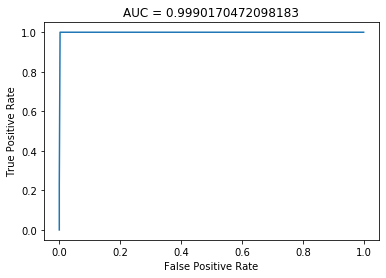

In [49]:
auc_roc(test_e, p)

In [50]:
np.unique(np.equal(test_e, p.round(0)), return_counts=True)

(array([False,  True]), array([   9, 2756]))

## Part 3: Training Regime

### Description

I randomly downsample the negative samples to a specified ratio of the size of the positive sample set. I then use 80% of each for training and 20% for testing. The learning rate, number of epochs, number of hidden nodes and bias are all tunable. 

### How was your training regime designed so as to prevent the negative training data from overwhelming the positive training data? 

I downsampled the negative samples to a tunable ratio with positive samples to allow flexibility in creating a more balanced training and testing set. 

### What was your stop criterion for convergence in your learned parameters? How did you decide this?

My training stops if mean standard error increases, mean standard error crosses below 0.00001 or the number of gradient descent rounds specified has been completed. 

## Cross Validation

### Hyperparameter choices

The hyperparameters that are tunable in my model, along with the defaults are listed below:
- number of nodes in the hidden layer (3)
- output dimensions (8)
- learning rate (0.01)
- regularization term (0.00001)
- epochs (100,000)
- bias (1)
- ratio of negative examples to positive examples in the training set
- percentage of master set that is used for training vs testing

### Describe how you set up your experiment to measure your system's performance. 

I implement k-fold cross validation and plot the ROC curve of each fold. 

### What set of learning parameters works the best? Please provide sample output from your system. 

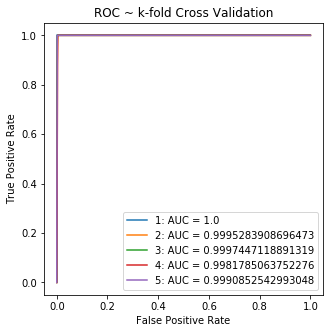

In [54]:
AUC, MSE = io.cross_validation(pos, neg, k=5, reg_term= 0.001, rounds=1000, learn_rate=0.01, num_hidden=3)

### What are the effects of altering your system (e.g. number of hidden units or choice of kernel function)? 

Decreasing the number of epochs or the training rate greatly decreases the performance of my neural net, which makes sense because that limits the time the system has to converge. With too few epochs and a small learning rate it may be impossible for the system to converge on a reasonable solution. Additionally, a more balanced dataset performed better on predictions from the same dataset, but not necessarily to an outside dataset with different +/- ratios. 

### What other parameters, if any, affect performance? 

Changing the regularization term and the bias also had some effect of performance, anecdotaly, but I did not tease out the direction of these effects on performance. 

## Test Data

In [55]:
test_seqs_string = io.read_test()
len(test_seqs_string)

3195

In [56]:
test_seqs = io.to_binary(test_seqs_string)
test_seqs = io.string_to_array(test_seqs)
nn = NN.NeuralNetwork(input = train, test_set = test_seqs, output_dim = 1, reg_term = 0, rounds=10000, expected_out = 'blind')
err = nn.fit()
p, mse = nn.predict()


In [57]:
df = pd.DataFrame(columns = ['Sequence','Prediction'])
df.Sequence = test_seqs_string
for i in range(len(p)):
    df.Prediction[i] = p[i][0]

In [58]:
df

,Sequence,Prediction
0,AAAAAAACGCAACTAAT,5.66468e-41
1,AAAAACACACATCTGGC,0.731059
2,AAAACCAAACACCTGAA,0.731059
3,AAAACCAAACAGCTCAG,0.731059
4,AAAACCAAACATATCAA,0.731059
...,...,...
3190,TTGTTCATACATTCTTA,5.66468e-41
3191,TTGTTCATATCTTCCAA,5.66468e-41
3192,TTTCTCATACACCTTTA,0.731059
3193,TTTTCCAAGCATTTGTA,5.66468e-41


In [59]:
df.to_csv('gilbertson_predictions.tsv', sep ='\t', header=False, index=False)